<a href="https://colab.research.google.com/github/AsadullahGalib007/QOSF-Screening-Task-Cohort-11/blob/main/Task_4_Quantum_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Binary Classification on Palmer Penguins

---


Author: Asadullah Bin Rahman | Date: 31 Oct, 2025

---


Compares Classical SVM, VQC, and QSVM across all species pairs using EDA-driven + PCA-based feature selection.

---



**Table of Contents**

>[Quantum Binary Classification on Palmer Penguins](#scrollTo=lQWLPsuEtgZ9)

>>[Setup & Imports](#scrollTo=zydgs3HTt0KK)

>>[Load & Explore Full Dataset](#scrollTo=Scp9DSSJt6na)

>>>[EDA: Pairplot of Numeric Features](#scrollTo=qnae91MxuEMo)

>>[Feature Selection Strategy](#scrollTo=p99ovyyHuEJw)

>>[All-Pair Binary Classification](#scrollTo=QteRjBZ0vH3Y)

>>[Quantum Encoding](#scrollTo=VyKlu-wtvQdA)

>>[Model Training & Evaluation (Per Pair & Feature Set)](#scrollTo=AeBZXJrHvXjg)

>>[Run All Experiments](#scrollTo=wLGMH8LIvcII)



## 1. Setup & Imports

In [ ]:
!pip install pennylane scikit-learn seaborn matplotlib pandas -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 29.7 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import warnings, time
warnings.filterwarnings("ignore")

np.random.seed(42); import random; random.seed(42)

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


## 2. Load & Explore Full Dataset

In [ ]:
penguins = sns.load_dataset("penguins")
data = penguins.copy().dropna(subset=['species'])  # Keep all species

print(f"Species: {data['species'].unique()}")
print(f"Shape: {data.shape}")
print(data['species'].value_counts())

Species: ['Adelie' 'Chinstrap' 'Gentoo']
Shape: (344, 7)
species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64


### EDA: Pairplot of Numeric Features

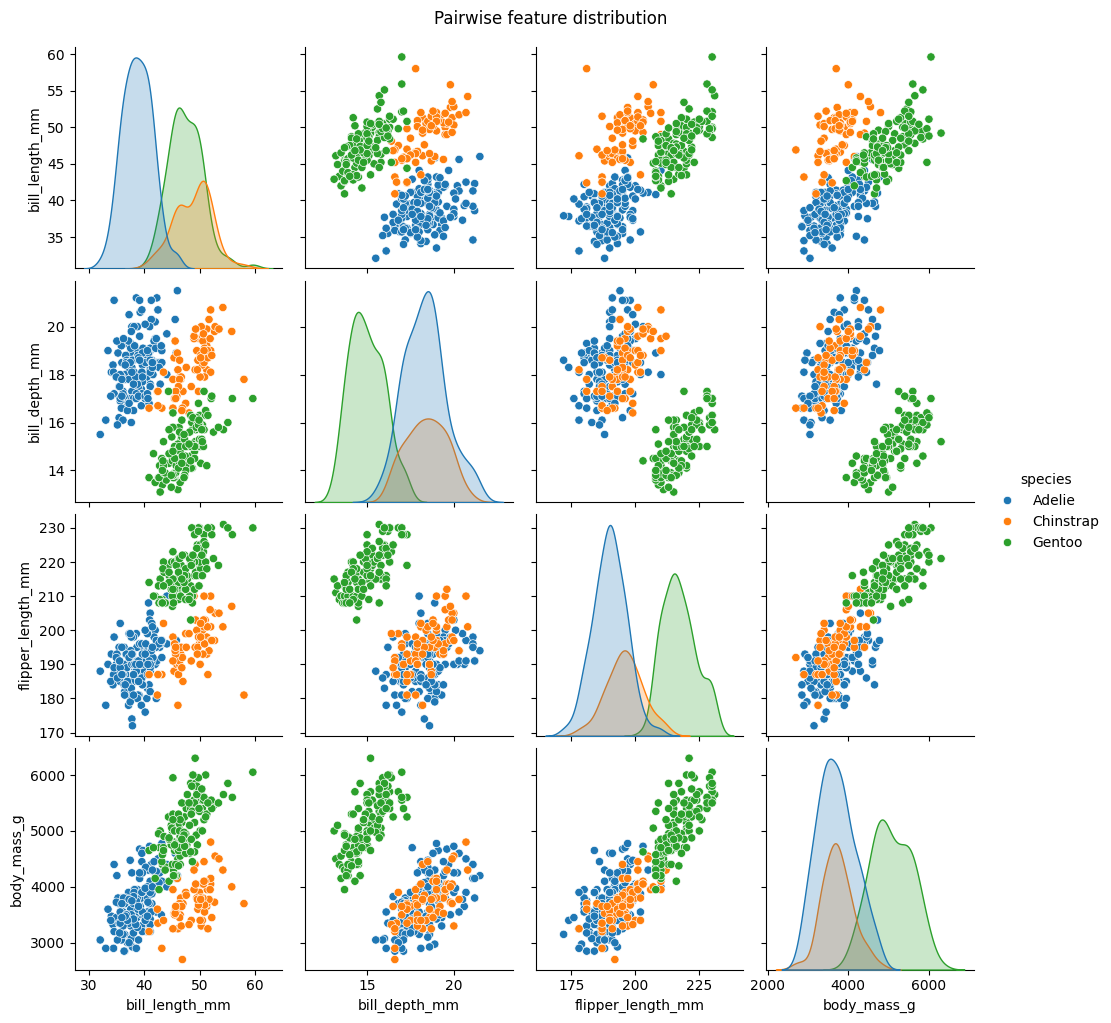

In [ ]:
# Pair-plot (helps choose EDA features)
sns.pairplot(data, hue='species',
             vars=['bill_length_mm','bill_depth_mm',
                   'flipper_length_mm','body_mass_g'])
plt.suptitle("Pairwise feature distribution", y=1.02)
plt.show()

## 3. Feature Selection Strategy

---


We compare two methods:

- **EDA-Driven**: Visual + correlation → select 2 most

- **PCA-Based**: Reduce to 2D using variance

In [ ]:
numeric_cols = ['bill_length_mm','bill_depth_mm',
                'flipper_length_mm','body_mass_g']

def impute_by_species(df):
    for c in numeric_cols:
        df[c] = df[c].fillna(df.groupby('species')[c].transform('median'))
    return df

data = impute_by_species(data)

# Standardise for PCA
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(data[numeric_cols])

pca = PCA(n_components=2)
X_pca_full = pca.fit_transform(X_std)
print(f"PCA variance explained: {pca.explained_variance_ratio_}")
# print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}, total: {pca.explained_variance_ratio_.sum():.3f}")

PCA variance explained: [0.68956008 0.19243331]


## 4. All-Pair Binary Classification

In [ ]:
pairs = list(combinations(['Adelie','Chinstrap','Gentoo'], 2))
datasets = {}

# ---- EDA feature map (hand-picked from pair-plot) ----
eda_map = {
    ('Adelie','Chinstrap'): ['flipper_length_mm','body_mass_g'],
    ('Adelie','Gentoo')   : ['bill_length_mm','flipper_length_mm'],
    ('Chinstrap','Gentoo'): ['bill_depth_mm','body_mass_g']
}

for s1,s2 in pairs:
    mask = data['species'].isin([s1,s2])
    df = data[mask].copy()
    y = df['species'].map({s1:1, s2:-1}).values

    # ---- EDA features ----
    cols = eda_map[(s1,s2)]
    X_eda = df[cols].values
    scaler_eda = MinMaxScaler()
    X_eda_scaled = scaler_eda.fit_transform(X_eda)

    # ---- PCA features (2-D) ----
    X_pca_pair = X_pca_full[mask]
    scaler_pca = MinMaxScaler()
    X_pca_scaled = scaler_pca.fit_transform(X_pca_pair)

    datasets[(s1,s2)] = {
        'y'          : y,
        'X_eda'      : X_eda_scaled,
        'eda_names'  : cols,
        'X_pca'      : X_pca_scaled
    }

## 5. Quantum Encoding

In [ ]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# ---------- Angle embedding (QSVM) ----------
def angle_embed(x):
    qml.AngleEmbedding(x, wires=range(n_qubits))

# --- QSVM KERNEL ---
@qml.qnode(dev)

def qkernel(x1, x2):
    angle_embed(x1)
    qml.adjoint(angle_embed)(x2)
    # Measure probability of |00⟩ state
    return qml.expval(qml.Projector([0, 0], wires=range(n_qubits)))

def kernel_matrix(X1, X2):
    return np.array([[qkernel(a, b) for b in X2] for a in X1])

# ---------- VQC state-prep (amplitude encoding) ----------
def vqc_prepare(X):
    pad = np.ones((len(X),2))*0.1
    Xp  = np.c_[X, pad]
    norm = np.linalg.norm(Xp, axis=1, keepdims=True)
    Xn  = Xp / norm

    def get_angles(x):
        b0 = 2*np.arcsin(np.sqrt(x[1]**2)/(np.sqrt(x[0]**2+x[1]**2)+1e-12))
        b1 = 2*np.arcsin(np.sqrt(x[3]**2)/(np.sqrt(x[2]**2+x[3]**2)+1e-12))
        b2 = 2*np.arcsin(np.sqrt(x[2]**2+x[3]**2)/np.linalg.norm(x)+1e-12)
        return np.array([b2, -b1/2, b1/2, -b0/2, b0/2])
    return np.array([get_angles(row) for row in Xn])

# ---------- VQC circuit (3 layers, trainable) ----------
def vqc_layer(w):
    for i in range(n_qubits):
        qml.Rot(*w[i], wires=i)
    qml.CNOT([0,1])

@qml.qnode(dev)
@qml.qnode(dev)
def vqc_circuit(weights, angles):
    # === State Preparation ===
    qml.RY(angles[0], 0); qml.CNOT([0,1])
    qml.RY(angles[1], 1); qml.CNOT([0,1])
    qml.RY(angles[2], 1); qml.PauliX(0)
    qml.CNOT([0,1]); qml.RY(angles[3], 1)
    qml.CNOT([0,1]); qml.RY(angles[4], 1); qml.PauliX(0)

    # === Ansatz ===
    for w in weights:
        qml.Rot(*w[0], wires=0)
        qml.Rot(*w[1], wires=1)
        qml.CNOT([0,1])

    return qml.expval(qml.PauliZ(0))  # ← Only return expval

## 6. Model Training & Evaluation (Per Pair & Feature Set)

In [ ]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

def train_vqc(X_ang, y, layers=3, epochs=200, lr=0.1, batch=32):
    w = 0.01 * np.random.randn(layers, n_qubits, 3, requires_grad=True)
    b = np.array(0.0, requires_grad=True)
    opt = NesterovMomentumOptimizer(lr)
    n = len(y)

    for it in range(epochs):
        idx = np.random.randint(0, n, min(batch, n))
        Xb, yb = X_ang[idx], y[idx]

        def cost(w, b):
            preds = [vqc_circuit(w, x) + b for x in Xb]
            return np.mean((yb - np.array(preds))**2)

        w, b = opt.step(cost, w, b)

        if (it + 1) % 50 == 0:
            preds = np.sign([vqc_circuit(w, x) + b for x in Xb])
            acc = accuracy_score(yb, preds)
            print(f"   VQC epoch {it+1:3d} – batch acc {acc:.3f}")
    return w, b

def eval_model(X_tr, X_val, y_tr, y_val, model):
    t0 = time.time()
    if model == 'svm':
        clf = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        prob = clf.predict_proba(X_val)[:,1]
        return (accuracy_score(y_val,pred),
                f1_score(y_val,pred),
                roc_auc_score(y_val,prob),
                time.time()-t0)

    elif model == 'qsvm':
        K_tr = kernel_matrix(X_tr, X_tr)
        K_val = kernel_matrix(X_val, X_tr)
        clf = SVC(kernel='precomputed', random_state=42)
        clf.fit(K_tr, y_tr)
        pred = clf.predict(K_val)
        return (accuracy_score(y_val, pred),
                f1_score(y_val, pred),
                0.5,
                time.time()-t0)

    elif model == 'vqc':
        X_tr_ang = vqc_prepare(X_tr)
        X_val_ang = vqc_prepare(X_val)
        w, b = train_vqc(X_tr_ang, y_tr, epochs=200, lr=0.1, batch=32)
        preds = np.sign([vqc_circuit(w, x) + b for x in X_val_ang])
        return (accuracy_score(y_val, preds),
                f1_score(y_val, preds),
                0.5,
                time.time()-t0)

## 7. Run All Experiments

In [9]:
summary = []

for (s1,s2), d in datasets.items():
    y = d['y']
    n_total = len(y)
    print(f"\n{'='*70}")
    print(f"{s1} vs {s2}  –  {n_total} samples total")
    print('='*70)

    for X_src, src_name in [(d['X_eda'],'EDA'), (d['X_pca'],'PCA')]:
        acc = {m:[] for m in ['svm','vqc','qsvm']}
        f1  = {m:[] for m in ['svm','vqc','qsvm']}
        tm  = {m:[] for m in ['svm','vqc','qsvm']}

        for fold, (tr, val) in enumerate(skf.split(X_src, y), 1):
            X_tr, X_val = X_src[tr], X_src[val]
            y_tr, y_val = y[tr], y[val]
            n_train = len(y_tr); n_test = len(y_val)

            print(f"\n  Fold {fold}/{n_folds} – train:{n_train}  test:{n_test}")

            for model in ['svm','vqc','qsvm']:
                a,f,auc,t = eval_model(X_tr, X_val, y_tr, y_val, model)
                acc[model].append(a); f1[model].append(f); tm[model].append(t)
                print(f"    {model.upper():5s}  Acc:{a:.4f}  F1:{f:.4f}  time:{t:.2f}s")

        # ----- per-pair summary -----
        summary.append({
            'Pair'      : f"{s1[:3]} vs {s2[:3]}",
            'Features'  : src_name,
            'SVM_Acc'   : f"{np.mean(acc['svm']):.4f} ± {np.std(acc['svm']):.3f}",
            'VQC_Acc'   : f"{np.mean(acc['vqc']):.4f} ± {np.std(acc['vqc']):.3f}",
            'QSVM_Acc'  : f"{np.mean(acc['qsvm']):.4f} ± {np.std(acc['qsvm']):.3f}",
            'SVM_F1'    : f"{np.mean(f1['svm']):.4f}",
            'VQC_F1'    : f"{np.mean(f1['vqc']):.4f}",
            'QSVM_F1'   : f"{np.mean(f1['qsvm']):.4f}",
            'TrainSize' : n_train,
            'TestSize'  : n_test
        })


Adelie vs Chinstrap  –  220 samples total

  Fold 1/5 – train:176  test:44
    SVM    Acc:0.7727  F1:0.8529  time:0.03s
   VQC epoch  50 – batch acc 0.719
   VQC epoch 100 – batch acc 0.594
   VQC epoch 150 – batch acc 0.656
   VQC epoch 200 – batch acc 0.688
    VQC    Acc:0.7045  F1:0.8116  time:204.06s
    QSVM   Acc:0.7045  F1:0.8267  time:75.57s

  Fold 2/5 – train:176  test:44
    SVM    Acc:0.7045  F1:0.8000  time:0.01s
   VQC epoch  50 – batch acc 0.812
   VQC epoch 100 – batch acc 0.812
   VQC epoch 150 – batch acc 0.719
   VQC epoch 200 – batch acc 0.688
    VQC    Acc:0.7045  F1:0.8267  time:188.47s
    QSVM   Acc:0.7045  F1:0.8267  time:76.51s

  Fold 3/5 – train:176  test:44
    SVM    Acc:0.7500  F1:0.8358  time:0.01s
   VQC epoch  50 – batch acc 0.781
   VQC epoch 100 – batch acc 0.688
   VQC epoch 150 – batch acc 0.781
   VQC epoch 200 – batch acc 0.812
    VQC    Acc:0.7045  F1:0.8219  time:189.16s
    QSVM   Acc:0.6818  F1:0.8108  time:79.76s

  Fold 4/5 – train:176 

In [10]:
# ==============================================================
# 8. Final table
# ==============================================================
print("\n" + "="*90)
print("FINAL 5-FOLD CV RESULTS (mean ± std)")
print("="*90)
df = pd.DataFrame(summary)
print(df[['Pair','Features','SVM_Acc','VQC_Acc','QSVM_Acc',
          'SVM_F1','VQC_F1','QSVM_F1','TrainSize','TestSize']].to_string(index=False))



FINAL 5-FOLD CV RESULTS (mean ± std)
      Pair Features        SVM_Acc        VQC_Acc       QSVM_Acc SVM_F1 VQC_F1 QSVM_F1  TrainSize  TestSize
Ade vs Chi      EDA 0.7364 ± 0.023 0.6955 ± 0.011 0.6909 ± 0.011 0.8239 0.8164  0.8172        176        44
Ade vs Chi      PCA 0.8273 ± 0.037 0.6864 ± 0.009 0.8409 ± 0.032 0.8819 0.8140  0.8903        176        44
Ade vs Gen      EDA 0.9892 ± 0.009 0.8990 ± 0.082 0.9927 ± 0.009 0.9899 0.8911  0.9932        221        55
Ade vs Gen      PCA 1.0000 ± 0.000 0.9928 ± 0.009 1.0000 ± 0.000 1.0000 0.9933  1.0000        221        55
Chi vs Gen      EDA 1.0000 ± 0.000 1.0000 ± 0.000 1.0000 ± 0.000 1.0000 1.0000  1.0000        154        38
Chi vs Gen      PCA 1.0000 ± 0.000 1.0000 ± 0.000 1.0000 ± 0.000 1.0000 1.0000  1.0000        154        38
